
<hr>
<h2 style="color:darkgreen; text-align:center;">Sciml Project</h2>
<hr>



# Physics-Informed Neural Network Modeling of Axisymmetric Jet Radius Evolution and Droplet Formation for Fuel Spray Atomization
* **Author** - Pulak Haldar*

**Reference:** 
 1. **[Dr.Abhishek Saini ]( https://www.linkedin.com/in/abhishek-saini-b5080443/)**  SciML Class Content (2025) at IIT mandi 
 2. Rayleigh–Plateau instabilities linear Theory
 3. T. W. Driessen, Drop formation from axi-symmetric fluid jets, Ph.D. dissertation, University of Twente, 2013.

## Problem Definition

**Governing Equation:**\
We Will model the time evolution of a liquid jet radius \( R(x, t) \) with an axial velocity field \( u(x, t) \), under the influence of surface tension:
$$\frac{\partial R}{\partial t} + u(x,t) \frac{\partial R}{\partial x} + \frac{1}{2} R(x,t) \frac{\partial u}{\partial x} = -\frac{\gamma}{\rho R(x,t)}, \qquad x \in [0, 1], \quad t \in [0, t]$$

where:
- **Uknown** - $R$ is the Jet Radius as a function of space and time, $R(x, t)$.
- **Uknown** - $u$ is the Axial Velocity as a function of space and time, $u(x, t)$.
- $\gamma$ is the Surface tension of the liquid ($\gamma=0.027$),
- $\rho$ is Liquid density ($\rho=830$),

**Initial Conditions:**\
At \( t = 0 \), the jet starts with a sinusoidal radius (**Rayleigh–Plateau instabilities**) and a linear velocity profile(gradually decreasing flow):
$$R(x, 0) = \sin(\pi x) , \quad u(x, 0) = 1 - 0.5 x $$.

**Boundary Condition:**\
Apply **Dirichlet boundary conditions** at the inlet $x=0$ and outlet  $x=1$: \
$$R(0, t) = 0 , \quad R(1, t) = 0 \hspace{4em} u(0, t) = 1 , \quad u(1, t) = 0.5$$

**Simplified Analytical Solution:**\
Assumptions:\
$ u(x,t) = constant = u_0 ,\qquad (\frac{\partial u}{\partial x} = 0 )$

The equation simplifies to:

$\frac{\partial R}{\partial t} + u_0 \frac{\partial R}{\partial x} = -\frac{\gamma}{\rho R}$

An approximate analytical solution via separation of variables:\
$R(x, t) = \sin(\pi x) \cdot e^{-\lambda t / 2} \qquad  where,\quad \lambda = \frac{2\gamma}{\rho R^2}\quad(effective- decay- rate) \qquad  and:u(x, t) \approx 1 - 0.5x \quad (assumed- steady-velocity)$\
This solution is **only approximate**.

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# Constants
rho = 830.0       # Density [kg/m^3]
gamma = 0.027      # Surface tension [N/m]

# Define the PINN model


class PINN(nn.Module):      $\hspace{5em}$ # Define a custom neural network class inheriting from PyTorch's nn.Module\
    def __init__(self):     \     
        super(PINN, self).__init__()     $\hspace{5em}$  # Initialize parent class (nn.Module)\
        self.net = nn.Sequential(    $\hspace{4em}$  # Define a feedforward neural network as a sequence of layers\
            nn.Linear(2, 100),      $\hspace{7em}$  # Input layer: takes 2 inputs (x, t), outputs 100 features\
            nn.Tanh(),              $\hspace{10em}$ # Activation function: hyperbolic tangent\
            nn.Linear(100, 100),    $\hspace{6em}$  # Hidden layer: 100 input features, 100 output features\
            nn.Tanh(),              $\hspace{10em}$  # Activation function\
            nn.Linear(100, 100),   $\hspace{6em}$   # Another hidden layer\
            nn.Tanh()               $\hspace{10em}$   # Activation function\
            nn.Linear(100, 100),    $\hspace{6em}$  # Yet another hidden layer\
            nn.Tanh(),              $\hspace{10em}$  # Activation function\
            nn.Linear(100, 2)       $\hspace{7em}$  # Output layer: produces 2 outputs (e.g., jet radius R and velocity u)\
        )

   def forward(self, x, t):      $\hspace{10em}$  # Forward pass: defines how input x and t pass through the network \
         return self.net(torch.cat([x, t], dim=1))    $\hspace{4em}$ # Concatenate x and t along the feature dimension before feeding into the net

In [17]:
# Define the PINN model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 2)  # Outputs: R and u
        )

    def forward(self, x, t):
        return self.net(torch.cat([x, t], dim=1))

# PDE residual
def pde_residual(model, x, t): $\hspace{7em}$  # Define function to compute residual of the governing PDE using the PINN model\
    x.requires_grad = True     $\hspace{10em}$  # Enable automatic differentiation w.r.t x\
    t.requires_grad = True     $\hspace{10em}$  # Enable automatic differentiation w.r.t t\
    out = model(x, t)         $\hspace{12em}$   # Forward pass: get predictions R and u from the model\
    R, u = out[:, 0:1], out[:, 1:2] $\hspace{9em}$     # Split the output: R (radius), u (velocity)

#Compute partial derivatives using autograd

R_t = torch.autograd.grad(R, t, torch.ones_like(R), retain_graph=True, create_graph=True) [0]  $\hspace{7em}$  # ∂R/∂t  \
    R_x = torch.autograd.grad(R, x, torch.ones_like(R), retain_graph=True, create_graph=True)[0] $\hspace{7em}$ # ∂R/∂x \
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), retain_graph=True, create_graph=True)[0] $\hspace{7em}$ # ∂u/∂x   

 
   return R_t + u * R_x + 0.5 * R * u_x + gamma / (rho * R) $\hspace{7em}$ 
   
   #Return the PDE residual (from Governing equation), Residual of the PDE equation (should be ≈ 0 for correct solution)

In [18]:
# PDE residual
def pde_residual(model, x, t):
    x.requires_grad = True
    t.requires_grad = True
    out = model(x, t)
    R, u = out[:, 0:1], out[:, 1:2]
    R_t = torch.autograd.grad(R, t, torch.ones_like(R), retain_graph=True, create_graph=True)[0]
    R_x = torch.autograd.grad(R, x, torch.ones_like(R), retain_graph=True, create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    return R_t + u * R_x + 0.5 * R * u_x + gamma / (rho * R)


# Initial condition (t = 0): R(x, 0) = sin(πx), u(x, 0) = 1 - 0.5 * x
def initial_condition(x):       $\hspace{7em}$    # Define a function that takes a tensor x as input\
    R0 = torch.sin(np.pi * x)    $\hspace{7em}$   #  computes sin(π * x_i) for each element in tensor x\
    u0 = 1 - 0.5 * x            $\hspace{10em}$    # subtracts 0.5 * x_i from 1 for each element in x\
    return R0, u0               $\hspace{11em}$    # Returns two tensors: R0 and u0, same shape as x


In [19]:
# Initial condition (t=0) : R(x, 0) = sin(pi x), u(x, 0) = 1 - 0.5 * x
def initial_condition(x):
    R0 = torch.sin(np.pi * x)
    u0 = 1 - 0.5 * x
    return R0, u0

# Boundary Condition
def boundary_condition(x):                        $\hspace{10em}$     # Define a function to apply boundary conditions at spatial boundaries\
    return torch.zeros_like(x), 1.0 - 0.5 * x      $\hspace{6em}$     # Returns two tensors:\
                                                  $\hspace{15em}$      #   → First: tensor of zeros with same shape/type as x (R = 0 at boundary)\
                                                 $\hspace{15em}$       #   → Second: tensor computed as 1.0 - 0.5 * x, element-wise (u = 1 - 0.5x)


In [20]:
def boundary_condition(x):
    return torch.zeros_like(x), 1.0 - 0.5 * x

# Data generation
def get_training_data(N_f=10000, N_i=100, N_b=100):         $\hspace{9em}$         # Function to generate training data for PDE, IC, and BC\
    x_f = torch.rand(N_f, 1)                                  $\hspace{15em}$       # Random x ∈ [0,1] for PDE residual points (N_f x 1 tensor)\
    t_f = torch.rand(N_f, 1)                                 $\hspace{15em}$        # Random t ∈ [0,1] for PDE residual points (N_f x 1 tensor)\

x_i = torch.linspace(0, 1, N_i).view(-1, 1)            $\hspace{10em}$          # Linearly spaced x ∈ [0,1] for initial condition (reshaped to column)\
t_i = torch.zeros_like(x_i)                        $\hspace{15em}$             # t = 0 for all initial points (same shape as x_i)\
R_i, u_i = initial_condition(x_i)                 $\hspace{13em}$               # Compute initial values R(x,0), u(x,0) from known functions\

x_b = torch.cat([torch.zeros(N_b, 1), torch.ones(N_b, 1)], dim=0)  $\hspace{7em}$  # Concatenate x = 0 and x = 1 to form boundary x values (2N_b x 1 tensor)\
t_b = torch.rand_like(x_b)                       $\hspace{15em}$             # Random t ∈ [0,1] for each boundary point (same shape as x_b)\
R_b, u_b = boundary_condition(x_b)             $\hspace{11em}$              # Compute boundary values R(x,t), u(x,t) using boundary condition function\

return x_f, t_f, x_i, t_i, R_i, u_i, x_b, t_b, R_b, u_b      $\hspace{7em}$     # Return all generated tensors for PDE, initial, and boundary conditions


In [21]:
# Data generation
def get_training_data(N_f=10000, N_i=100, N_b=100):
    x_f = torch.rand(N_f, 1)
    t_f = torch.rand(N_f, 1)
    x_i = torch.linspace(0, 1, N_i).view(-1, 1)
    t_i = torch.zeros_like(x_i)
    R_i, u_i = initial_condition(x_i)
    x_b = torch.cat([torch.zeros(N_b, 1), torch.ones(N_b, 1)], dim=0)
    t_b = torch.rand_like(x_b)
    R_b, u_b = boundary_condition(x_b)
    return x_f, t_f, x_i, t_i, R_i, u_i, x_b, t_b, R_b, u_b

# Loss function
def compute_loss(model, x_f, t_f, x_i, t_i, R_i, u_i, x_b, t_b, R_b, u_b):  $\hspace{7em}$      # Define total loss for training the PINN \
    f = pde_residual(model, x_f, t_f)                     $\hspace{12em}$           # Compute PDE residual at collocation points (shape: [N_f, 1])

 out_i = model(x_i, t_i)                                   $\hspace{14em}$                 # Predict model outputs at initial condition points\
 R_i_pred, u_i_pred = out_i[:, 0:1], out_i[:, 1:2]           $\hspace{7em}$                 # Split output into R and u predictions (initial)

 out_b = model(x_b, t_b)                                     $\hspace{13em}$                 # Predict model outputs at boundary condition points\
 R_b_pred, u_b_pred = out_b[:, 0:1], out_b[:, 1:2]         $\hspace{7em}$                   # Split output into R and u predictions (boundary)

 loss_pde = torch.mean(f**2)              $\hspace{13em}$                            # Mean squared PDE residual loss: enforces governing equation\
 loss_ic = torch.mean((R_i_pred - R_i)**2 + (u_i_pred - u_i)**2)   $\hspace{9em}$          # MSE loss for initial condition: R(x,0), u(x,0)\
 loss_bc = torch.mean((R_b_pred - R_b)**2 + (u_b_pred - u_b)**2)  $\hspace{9em}$           # MSE loss for boundary condition: R(0,t)/R(1,t), u(0,t)/u(1,t)

 return loss_pde + loss_ic + loss_bc       $\hspace{12em}$                                  # Total loss: sum of PDE, initial, and boundary losses


In [22]:
# Loss function
def compute_loss(model, x_f, t_f, x_i, t_i, R_i, u_i, x_b, t_b, R_b, u_b):
    f = pde_residual(model, x_f, t_f)
    out_i = model(x_i, t_i)
    R_i_pred, u_i_pred = out_i[:, 0:1], out_i[:, 1:2]
    out_b = model(x_b, t_b)
    R_b_pred, u_b_pred = out_b[:, 0:1], out_b[:, 1:2]
    loss_pde = torch.mean(f**2)
    loss_ic = torch.mean((R_i_pred - R_i)**2 + (u_i_pred - u_i)**2)
    loss_bc = torch.mean((R_b_pred - R_b)**2 + (u_b_pred - u_b)**2)
    return loss_pde + loss_ic + loss_bc

# Training loop
def train(model, data, epochs=5000):  $\hspace{12em}$                    # Define training function with model, data, and number of epochs\
    x_f, t_f, x_i, t_i, R_i, u_i, x_b, t_b, R_b, u_b = data   $\hspace{9em}$ # Unpack training data for PDE, initial, and boundary conditions

 optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)   $\hspace{9em}$    # Initialize Adam optimizer with learning rate = 1e-3

for epoch in range(epochs):      $\hspace{14em}$                             # Loop over training epochs\
      optimizer.zero_grad()      $\hspace{14em}$                             # Clear previous gradients (important before backprop)
        
 loss = compute_loss(model, x_f, t_f, x_i, t_i, R_i, u_i, x_b, t_b, R_b, u_b)    $\hspace{9em}$ # Compute total loss using current model parameters
        
loss.backward()             $\hspace{14em}$                             # Perform backpropagation: compute gradients of loss w.r.t. model params
        
optimizer.step()        $\hspace{14em}$                                 # Update model parameters using gradients (1 optimization step)

 if epoch % 500 == 0:              $\hspace{14em}$                       # Print loss every 500 epochs for monitoring
    print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

 return model                             $\hspace{14em}$                 # Return the trained model


In [23]:
# Training loop
def train(model, data, epochs=5000):
    x_f, t_f, x_i, t_i, R_i, u_i, x_b, t_b, R_b, u_b = data
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = compute_loss(model, x_f, t_f, x_i, t_i, R_i, u_i, x_b, t_b, R_b, u_b)
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.6f}")
    return model

# Function to extract predicted R and u over the domain
def get_model_outputs(model, x_points=100, t_points=100): $\hspace{9em}$         # Evaluate model predictions over a 2D (x, t) grid\
    x = torch.linspace(0, 1, x_points).view(-1, 1)  $\hspace{13em}$             # Create 1D tensor of x values ∈ [0, 1], shape: (x_points, 1)\
    t = torch.linspace(0, 1, t_points).view(-1, 1)  $\hspace{13em}$             # Create 1D tensor of t values ∈ [0, 1], shape: (t_points, 1)

X, T = torch.meshgrid(x.squeeze(), t.squeeze(), indexing='ij') $\hspace{9em}$   # Generate 2D grid: X[i,j] = x_i, T[i,j] = t_j\
                              $\hspace{15em}$                                    # Shape of X and T: (x_points, t_points)

x_flat = X.reshape(-1, 1)        $\hspace{14em}$                                # Flatten 2D grid to column vector (x_points * t_points, 1)\
 t_flat = T.reshape(-1, 1)       $\hspace{14em}$                                # Flatten t grid similarly

with torch.no_grad():        $\hspace{15em}$                                # Disable gradient tracking during inference\
    output = model(x_flat, t_flat) $\hspace{13em}$                          # Run model prediction on all grid points\
     R_pred = output[:, 0].reshape(x_points, t_points) $\hspace{9em}$      # Extract R predictions and reshape to 2D grid\
     u_pred = output[:, 1].reshape(x_points, t_points)   $\hspace{9em}$    # Extract u predictions and reshape to 2D grid

return X, T, R_pred, u_pred           $\hspace{14em}$                      # Return grid and predicted R, u values (all shape: x_points × t_points)


In [24]:
# Function to extract predicted R and u over the domain
def get_model_outputs(model, x_points=100, t_points=100):
    x = torch.linspace(0, 1, x_points).view(-1, 1)
    t = torch.linspace(0, 1, t_points).view(-1, 1)
    X, T = torch.meshgrid(x.squeeze(), t.squeeze(), indexing='ij')
    x_flat = X.reshape(-1, 1)
    t_flat = T.reshape(-1, 1)
    with torch.no_grad():
        output = model(x_flat, t_flat)
        R_pred = output[:, 0].reshape(x_points, t_points)
        u_pred = output[:, 1].reshape(x_points, t_points)
    return X, T, R_pred, u_pred

# Run PINNs training
model = PINN()      $\hspace{9em}$                # Instantiate the Physics-Informed Neural Network model\
data = get_training_data()   $\hspace{9em}$       # Generate training data: PDE points, initial and boundary conditions\
trained_model = train(model, data) $\hspace{9em}$     # Train the model using the specified training loop\
"PINNs training complete."     $\hspace{9em}$         # Status message (note: has no effect unless printed)


In [25]:
# Run PINNs training
model = PINN()
data = get_training_data()
trained_model = train(model, data)
"PINNs training complete."

Epoch 0: Loss = 1.555551
Epoch 500: Loss = 0.345636
Epoch 1000: Loss = 0.263635
Epoch 1500: Loss = 0.253760
Epoch 2000: Loss = 0.238526
Epoch 2500: Loss = 0.210481
Epoch 3000: Loss = 0.170906
Epoch 3500: Loss = 0.123979
Epoch 4000: Loss = 0.086733
Epoch 4500: Loss = 20.692703


'PINNs training complete.'

# Get predicted data of R and u
X, T, R_data, u_data = get_model_outputs(trained_model)   $\hspace{9em}$     # Evaluate trained model over (x, t) domain grid

R_data.shape, u_data.shape            $\hspace{9em}$              # Confirm output shapes: should be (x_points, t_points)


In [26]:
# Get predicted data of R and u
X, T, R_data, u_data = get_model_outputs(trained_model)

R_data.shape, u_data.shape  # Confirm the output dimensions

(torch.Size([100, 100]), torch.Size([100, 100]))

# Print values of R(x,t) & u(x,t)
print("Sample of R(x,t):")      $\hspace{9em}$                     # Print a label for jet radius sample output\
print(R_data[:5, :5])       $\hspace{9em}$                         # Print a 5x5 slice: first 5 x-values × first 5 t-values of R(x,t)

print("\nSample of u(x,t):")         $\hspace{9em}$                # Print a label for velocity sample output\
print(u_data[:5, :5])           $\hspace{9em}$                     # Print a 5x5 slice: first 5 x-values × first 5 t-values of u(x,t)


In [27]:
print("Sample of R(x,t):")
print(R_data[:5, :5])  # print first 5 x-values and first 5 time steps

print("\nSample of u(x,t):")
print(u_data[:5, :5])


Sample of R(x,t):
tensor([[0.8098, 0.8102, 0.8105, 0.8109, 0.8113],
        [0.8102, 0.8106, 0.8110, 0.8114, 0.8118],
        [0.8107, 0.8111, 0.8114, 0.8118, 0.8122],
        [0.8111, 0.8115, 0.8119, 0.8122, 0.8126],
        [0.8116, 0.8119, 0.8123, 0.8127, 0.8130]])

Sample of u(x,t):
tensor([[0.8211, 0.8197, 0.8183, 0.8171, 0.8158],
        [0.8180, 0.8166, 0.8153, 0.8140, 0.8128],
        [0.8149, 0.8136, 0.8123, 0.8111, 0.8099],
        [0.8120, 0.8107, 0.8094, 0.8082, 0.8071],
        [0.8091, 0.8078, 0.8066, 0.8055, 0.8044]])


# Save Data
np.savetxt("R_data.csv", R_data.numpy(), delimiter=",")  $\hspace{9em}$    # Convert R_data (torch.Tensor) to NumPy array and save as CSV\
np.savetxt("u_data.csv", u_data.numpy(), delimiter=",")  $\hspace{9em}$    # Convert u_data to NumPy and save with comma-separated values


In [28]:
np.savetxt("R_data.csv", R_data.numpy(), delimiter=",")
np.savetxt("u_data.csv", u_data.numpy(), delimiter=",")


# Plote the Figure
time_indices = [0, 12, 25, 37, 49]             $\hspace{9em}$         # Select time indices for t ≈ 0.0, 0.25, 0.5, 0.75, 1.0 

**=== FIGURE 1: R(x, t) ===**\
plt.figure(figsize=(14, 5))                $\hspace{9em}$            # Create a wide figure with 2 subplots side by side

**Left: PINNs Prediction**
plt.subplot(1, 2, 1)                     $\hspace{9em}$                  # Left subplot (1 row, 2 columns, index 1)\
for idx in time_indices:\
    plt.plot(X[:, 0], R_data[:, idx], label=f't = {T[0, idx]:.2f}')   $\hspace{9em}$ # Plot predicted R(x) at each selected t\
plt.title('PINNs Prediction of R(x, t)')\
plt.xlabel('x')\
plt.ylabel('R')\
plt.grid(True)\
plt.legend()

**Right: Analytical Solution**\
plt.subplot(1, 2, 2)                $\hspace{9em}$                      # Right subplot (index 2)\
for idx in time_indices:\
    plt.plot(X[:, 0], R_exact[:, idx], '--', label=f't = {T[0, idx]:.2f}')   $\hspace{9em}$ # Plot analytical R(x) with dashed lines\
plt.title('Analytical Solution of R(x, t)')\
plt.xlabel('x')\
plt.ylabel('R')\
plt.grid(True)\
plt.legend()

plt.tight_layout()\
plt.show()                                  $\hspace{9em}$                # Display figure 1 (R vs x at multiple times)

**=== FIGURE 2: u(x, t) ===**\
plt.figure(figsize=(14, 5))             $\hspace{9em}$                    # New figure for velocity comparison

**Left: PINNs Prediction**\
plt.subplot(1, 2, 1)\
for idx in time_indices:\
    plt.plot(X[:, 0], u_data[:, idx], label=f't = {T[0, idx]:.2f}')   $\hspace{9em}$ # Plot predicted u(x) at selected t\
plt.title('PINNs Prediction of u(x, t)')\
plt.xlabel('x')\
plt.ylabel('u')\
plt.grid(True)\
plt.legend()

**Right: Analytical Solution**\
plt.subplot(1, 2, 2)\
for idx in time_indices:\
    plt.plot(X[:, 0], u_exact[:, idx], '--', label=f't = {T[0, idx]:.2f}')   $\hspace{9em}$ # Plot analytical u(x) with dashed lines\
plt.title('Analytical Solution of u(x, t)')\
plt.xlabel('x')\
plt.ylabel('u')\
plt.grid(True)\
plt.legend()

plt.tight_layout()\
plt.show()                                        $\hspace{9em}$            # Display figure 2 (u vs x at multiple times)


NameError: name 'R_exact' is not defined

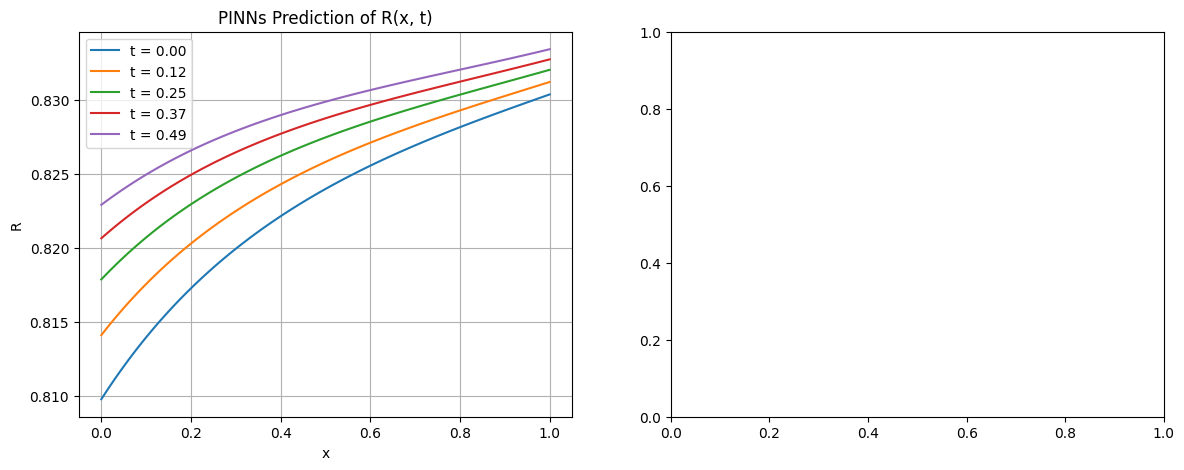

In [30]:
# Time slices to show (adjust as needed)
time_indices = [0, 12, 25, 37, 49]  # Corresponds to t ~ 0, 0.25, 0.5, 0.75, 1.0

# === FIGURE 1: R(x, t) ===
plt.figure(figsize=(14, 5))

# Left: PINNs Prediction
plt.subplot(1, 2, 1)
for idx in time_indices:
    plt.plot(X[:, 0], R_data[:, idx], label=f't = {T[0, idx]:.2f}')
plt.title('PINNs Prediction of R(x, t)')
plt.xlabel('x')
plt.ylabel('R')
plt.grid(True)
plt.legend()

# Right: Analytical Solution
plt.subplot(1, 2, 2)
for idx in time_indices:
    plt.plot(X[:, 0], R_exact[:, idx], '--', label=f't = {T[0, idx]:.2f}')
plt.title('Analytical Solution of R(x, t)')
plt.xlabel('x')
plt.ylabel('R')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# === FIGURE 2: u(x, t) ===
plt.figure(figsize=(14, 5))

# Left: PINNs Prediction
plt.subplot(1, 2, 1)
for idx in time_indices:
    plt.plot(X[:, 0], u_data[:, idx], label=f't = {T[0, idx]:.2f}')
plt.title('PINNs Prediction of u(x, t)')
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.legend()

# Right: Analytical Solution
plt.subplot(1, 2, 2)
for idx in time_indices:
    plt.plot(X[:, 0], u_exact[:, idx], '--', label=f't = {T[0, idx]:.2f}')
plt.title('Analytical Solution of u(x, t)')
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# Comparison of PINN vs Analytical Solution
**Time indices for comparison**\
time_indices = [0, 12, 25, 37, 49]          $\hspace{9em}$            # Time slice indices: t ≈ 0.00, 0.25, 0.50, 0.75, 1.00

**Plot R(x, t) comparison**\
plt.figure(figsize=(8, 5))                      $\hspace{9em}$              # Create a figure for comparing R(x, t)\
for idx in time_indices:\
    plt.plot(X[:, 0], R_data[:, idx], label=f'PINN t={T[0, idx]:.2f}') $\hspace{9em}$    # Plot R from PINN (solid line)\
    plt.plot(X[:, 0], R_exact[:, idx], '--', label=f'Exact t={T[0, idx]:.2f}') $\hspace{9em}$ # Plot R from exact solution (dashed line)\
plt.xlabel('x')\
plt.ylabel('R(x, t)')\
plt.title('Comparison of R(x, t) PINN vs Analytical Solution')\
plt.legend()\
plt.grid(True)\
plt.tight_layout()\
plt.show()                                    $\hspace{9em}$                # Display the R(x, t) comparison plot

**Plot u(x, t) comparison**\
plt.figure(figsize=(8, 5))                     $\hspace{9em}$               # Create a new figure for comparing u(x, t)\
for idx in time_indices:\
    plt.plot(X[:, 0], u_data[:, idx], label=f'PINN t={T[0, idx]:.2f}') $\hspace{9em}$    # Plot u from PINN (solid line)\
    plt.plot(X[:, 0], u_exact[:, idx], '--', label=f'Exact t={T[0, idx]:.2f}')  $\hspace{9em}$ # Plot u from exact solution (dashed line)\
plt.xlabel('x')\
plt.ylabel('u(x, t)')\
plt.title('Comparison of u(x, t) PINN vs Analytical Solution')\
plt.legend()\
plt.grid(True)\
plt.tight_layout()\
plt.show()                                     $\hspace{9em}$               # Display the u(x, t) comparison plot


In [ ]:
# Time indices for comparison
time_indices = [0, 12, 25, 37, 49]  # corresponds to t ~ 0, 0.25, 0.5, 0.75, 1.0

# Plot R(x, t) comparison
plt.figure(figsize=(8, 5))
for idx in time_indices:
    plt.plot(X[:, 0], R_data[:, idx], label=f'PINN t={T[0, idx]:.2f}')
    plt.plot(X[:, 0], R_exact[:, idx], '--', label=f'Exact t={T[0, idx]:.2f}')
plt.xlabel('x')
plt.ylabel('R(x, t)')
plt.title('Comparison of R(x, t) PINN vs Analytical Solution')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot u(x, t) comparison
plt.figure(figsize=(8, 5))
for idx in time_indices:
    plt.plot(X[:, 0], u_data[:, idx], label=f'PINN t={T[0, idx]:.2f}')
    plt.plot(X[:, 0], u_exact[:, idx], '--', label=f'Exact t={T[0, idx]:.2f}')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.title('Comparison of u(x, t) PINN vs Analytical Solution')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Derivation of Governing Equation 

The PDE governing the evolution of a slender axisymmetric liquid jet radius $R(x,t)$ under the influence of an axial velocity field $u(x,t)$ and surface tension.


**Assumptions**

1. *Axisymmetric slender jet*: Radius $(R)$ is small compared to axial length.  
2. *Incompressible liquid* of density $(\rho)$ .
3. *Surface tension* $(\gamma)$ acts to minimize surface area, causing capillary pressure.  
4. Neglect *viscous* and *gravitational* forces (high Weber and low Reynolds numbers regime).  

These assumptions reduce the full Navier–Stokes equations to a 1D model capturing capillary-driven dynamics and axial stretching.


**Mass Conservation (Continuity)**

For incompressible flow, mass flux through any cross-section is constant:


$\frac{\partial}{\partial t} (A) + \frac{\partial}{\partial x} \bigl(u\, A\bigr) = 0. \qquad where \quad A=(\pi R^2)$


$
\frac{\partial}{\partial t} (\pi R^2) + \frac{\partial}{\partial x} \bigl(u\,\pi R^2\bigr) = 0.
$

$
2R \frac{\partial R}{\partial t} + 2R\,u \frac{\partial R}{\partial x} + R^2 \frac{\partial u}{\partial x} = 0.$ $\quad$ (Divide by $(\pi)$ and expand)


$
\boxed{\frac{\partial R}{\partial t} + u \frac{\partial R}{\partial x} + \tfrac12\,R \frac{\partial u}{\partial x} = 0.}
$ $\quad$This term captures axial stretching $(\frac{\partial R}{\partial x})$ and advection of the interface.


$
\Delta p = p_{\text{in}} - p_{\text{out}} = \frac{\gamma}{R}.$ $\quad$ At a curved interface, surface tension generates a pressure (Laplace Pressure) this pressure acts inward, creating a radial acceleration.


$
a_r = \frac{F}{m} = -\frac{\Delta p}{\rho} = -\frac{\gamma}{\rho\,R}.$$\quad$(Here, negative sign indicates collapse of radius under capillary forces.)

**Final Governing PDE**

Add the capillary acceleration as a sink term in the kinematic equation & nonlinear convection–reaction equation is :


$\boxed{\frac{\partial R}{\partial t} + u(x,t)\,\frac{\partial R}{\partial x}+ \tfrac12\,R(x,t)\,\frac{\partial u}{\partial x}= -\frac{\gamma}{\rho\,R(x,t)}}$


- Left-hand side: kinematics (advection + stretching). $\quad$ &  $\quad$ Right-hand side: capillary collapse.

- When $(u)$ increases along $(x)$, the jet thins due to axial stretching.Surface tension always acts to minimize surface area, reducing $(R)$ locally.Competition between flow-driven stretch and capillary collapse governs breakup.
